In [149]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

## Reading Data

In [104]:
dataraw = pd.read_csv("data/anime.csv")

dataraw.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


## Cleaning Data

In [12]:
data = dataraw.dropna()
data = data.drop_duplicates()

data = data[data["Score"] != "Unknown"]

data = data.reset_index()

data["Score"] = pd.to_numeric(data["Score"], errors = "coerce")

## Question: What genres tend to give the highest ratings?

In [ ]:
#removing entries where genre is unknown
genreData = data[data["Genres"] != "Unknown"]
genreData = genreData.reset_index()

#extracting genres
genres = {}

for index, row in genreData.iterrows():
    temp = row["Genres"].split(", ")
    for x in temp:
        genres[x] = 0

#calculating averages
toRemove = []

for genre in genres:
    tempdf = genreData[genreData["Genres"].str.contains(genre)]
    if len(tempdf) >= 100:
        genres[genre] = tempdf["Score"].mean()
    else:
        genres[genre] = -1
        toRemove.append(genre)

for genre in toRemove:
    genres.pop(genre)

#visualization
genresSorted = sorted(genres.items(), key=lambda kv: (kv[1], kv[0]))
categories, values = zip(*genresSorted)

plt.figure(figsize=(6, 9))

chart = plt.barh(categories, values)

plt.title("Average MyAnimeList Rating Per Genre")
plt.xlim(5, 7.5)
plt.bar_label(chart, fmt = "{:.2f}", padding = -22, size = "small", color = "white")
plt.margins(y = 0.03)
plt.xlabel("Average Rating")
plt.show()

## Question: Does the age of an anime have any correlation to how highly it is rated?

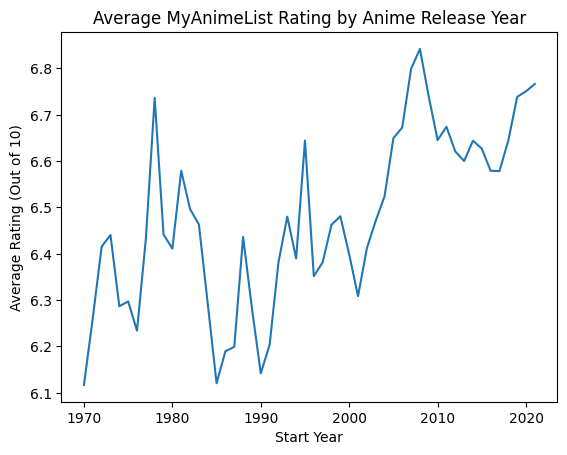

In [33]:
#cleaning
ageData = data[data["Aired"] != "Unknown"]
ageData = ageData.reset_index()

#extracting start year
startYear = []

for index, row in ageData.iterrows():
    dates = row["Aired"].split(" to ")
    temp = dates[0].split(", ")
    if len(temp) > 1:
        startYear.append(temp[1])
    else:
        startYear.append("Unknown")

ageData["Start Year"] = startYear
ageData = ageData.drop("level_0", axis = 1)

yearData = ageData[ageData["Start Year"] != "Unknown"]
yearData = yearData.reset_index()

yearData["Start Year"] = pd.to_numeric(yearData["Start Year"])


avgRatingByYear = yearData.loc[yearData["Start Year"] >= 1970].groupby("Start Year")["Score"].mean()

plt.figure()
avgRatingByYear.plot(title = "Average MyAnimeList Rating by Anime Release Year", ylabel = "Average Rating (Out of 10)")
plt.show()

## Question: How do anime with original storylines compare to anime based on pre-existing sources, such as manga or light novels? Do they tend to perform better? Worse?


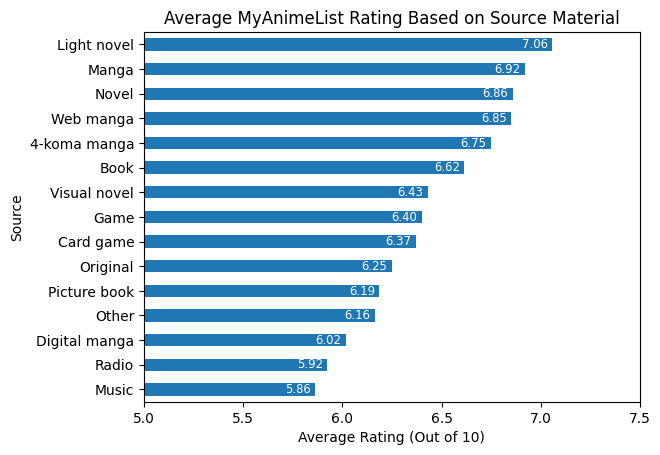

In [32]:
#cleaning
sourceData = data[data["Source"] != "Unknown"]
sourceData = sourceData.reset_index()

avgRatingBySource = sourceData.groupby("Source")["Score"].mean()
avgRatingBySource = avgRatingBySource.sort_values()

plt.figure()
chart = avgRatingBySource.plot.barh(title = "Average MyAnimeList Rating Based on Source Material", xlabel = "Average Rating (Out of 10)")
plt.xlim(5, 7.5)
plt.bar_label(chart.containers[0], fmt = "{:.2f}", padding = -22, size = "small", color = "white")
plt.show()

## Question: Does having a higher number of user ratings tend to improve or drag down user score?

In [ ]:
scorersData = data.copy()

colNames = ["Score-10", "Score-9", "Score-8", "Score-7", "Score-6", "Score-5", "Score-4", "Score-3", "Score-2", "Score-1"]

for name in colNames:
    scorersData = scorersData[scorersData[name] != "Unknown"]

for name in colNames:
    scorersData[name] = pd.to_numeric(scorersData[name], errors = "coerce")

scorersData["Num Ratings"] = scorersData[colNames].sum(axis = 1)

scorersData = scorersData[scorersData["Num Ratings"] > 0]

scorersData.reset_index()

scatterPlot = sns.lmplot(data = scorersData, x = "Num Ratings", y = "Score", logx = True, height = 5, aspect = 1.5, line_kws={"color": "red"}, scatter_kws={"s": 20})

plt.ylim(1, 10)

plt.title("MyAnimeList Score Based On Number of Ratings")
plt.xlabel("Number of Ratings (Millions)")

plt.show()

In [ ]:
scatterPlot = sns.lmplot(data = scorersData, x = "Num Ratings", y = "Score", logx = True, height = 5, aspect = 1.5, line_kws={"color": "red"}, scatter_kws={"s": 20})

plt.xlim(0, 50000)

plt.title("MyAnimeList Score Based On Number of Ratings")
plt.xlabel("Number of Ratings")

plt.show()